In [1]:
import sys
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree

sys.path.append('../')
from envir import config

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Load Data

In [2]:
df = pd.read_csv(config.dataFol+'all_cleaned_wsp_sonyc_birds.csv')

#### Processing Data
* convert timestamps from UTC to US/Eastern

In [3]:
df['timestamp_est'] = pd.to_datetime(df['timestamp_utc']) \
    .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df['year'] = pd.DatetimeIndex(df['timestamp_est']).year
df['month'] = pd.DatetimeIndex(df['timestamp_est']).month
df['week'] = pd.DatetimeIndex(df['timestamp_est']).weekofyear
df['day'] = pd.DatetimeIndex(df['timestamp_est']).dayofyear
df['hour'] = pd.DatetimeIndex(df['timestamp_est']).hour

In [4]:
df.shape

(756880, 34)

In [5]:
df = df.loc[(df.hour>=4)&(df.hour<=8)]

In [6]:
df.dtypes

timestamp_utc                                        object
sonyc_sensor_id                                      object
sonyc_sensor_name                                    object
dBAS_lin_mean                                       float64
l1                                                  float64
l10                                                 float64
l5                                                  float64
l90                                                 float64
count_of_positive_predictions                       float64
pct_positive_predictions                            float64
avg_mtr_#/km/h                                      float64
avg_mt_#/km                                         float64
avg_height_m                                        float64
temp_celcius                                        float64
dewp_celcius                                        float64
rh_percentage                                       float64
wind_dir                                

In [7]:
df.sonyc_sensor_name.unique()

array(['19 Washington Square North', 'Juan Carlos',
       'Shimkin Reading Room', '4 Washington Square North',
       'Kimmel Center'], dtype=object)

In [8]:
df.columns

Index(['timestamp_utc', 'sonyc_sensor_id', 'sonyc_sensor_name',
       'dBAS_lin_mean', 'l1', 'l10', 'l5', 'l90',
       'count_of_positive_predictions', 'pct_positive_predictions',
       'avg_mtr_#/km/h', 'avg_mt_#/km', 'avg_height_m', 'temp_celcius',
       'dewp_celcius', 'rh_percentage', 'wind_dir', 'wind_speed_mph',
       'sea_level_pressure_mb', 'precipitation_mm', 'visibility_miles',
       'gust_mph', 'peak_wind_gust_mph', 's_19WashingtonSquareNorth',
       's_juanCarlos', 's_shimkinReadingRoom', 's_4WashingtonSquareNorth',
       's_kimmelCenter', 'timestamp_est', 'year', 'month', 'week', 'day',
       'hour'],
      dtype='object')

### Decision Tree Model

In [9]:
X = df[['dBAS_lin_mean', 'l90',
       'avg_mtr_#/km/h', 'avg_height_m', 'temp_celcius',
       'wind_dir', 'wind_speed_mph', 'precipitation_mm', 'visibility_miles',
       'year', 'month', 'week', 'day', 'hour']]
y = df.pct_positive_predictions

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, make_scorer

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=0)

In [30]:
scoring = make_scorer(r2_score)
g_cv = GridSearchCV(tree.DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10),
                          'max_depth': range(2, 10), 
                          'max_leaf_nodes': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
#print(result)
r2_score(y_test, g_cv.best_estimator_.predict(X_test))

0.12216715621074259

In [41]:
result = pd.DataFrame(result)
result[result.rank_test_score==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
248,0.287315,0.001494,0.004853,0.000059,5,9,2,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1
249,0.298832,0.005029,0.005509,0.000329,5,9,3,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1
250,0.287021,0.001175,0.004848,0.000080,5,9,4,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1
251,0.286833,0.000625,0.004829,0.000053,5,9,5,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1
252,0.287092,0.001787,0.004814,0.000165,5,9,6,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1
253,0.286861,0.001635,0.004782,0.000035,5,9,7,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1
254,0.286480,0.001183,0.004749,0.000027,5,9,8,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1
255,0.286965,0.001339,0.004794,0.000043,5,9,9,"{'max_depth': 5, 'max_leaf_nodes': 9, 'min_sam...",0.110852,0.127978,0.11534,0.132774,0.126092,0.122607,0.00819,1


In [42]:
clf = tree.DecisionTreeRegressor(max_depth=5, max_leaf_nodes=9, random_state=12345)
clf = clf.fit(X, y)

In [43]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names =X.columns,
                                class_names = y,
                                filled=True, rounded=True,
                                special_characters=True)  

In [44]:
graph = graphviz.Source(dot_data)

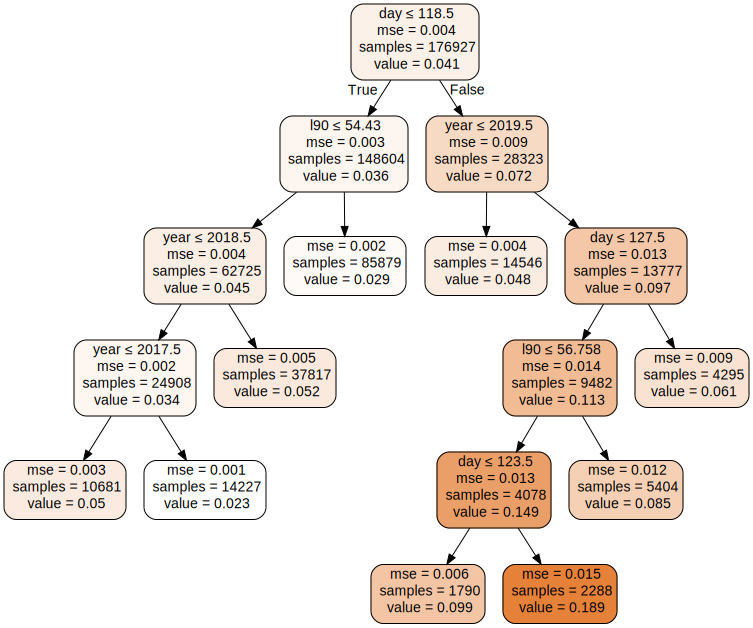

In [45]:
graph

In [46]:
clf.feature_importances_

array([0.        , 0.20790569, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.28230608,
       0.        , 0.        , 0.50978823, 0.        ])

In [47]:
pd.DataFrame(X.columns, clf.feature_importances_)

,0
0.000000,dBAS_lin_mean
0.207906,l90
0.000000,avg_mtr_#/km/h
0.000000,avg_height_m
0.000000,temp_celcius
0.000000,wind_dir
0.000000,wind_speed_mph
0.000000,precipitation_mm
0.000000,visibility_miles
0.282306,year


In [27]:
clf.score(X,y)

0.3276399742488577